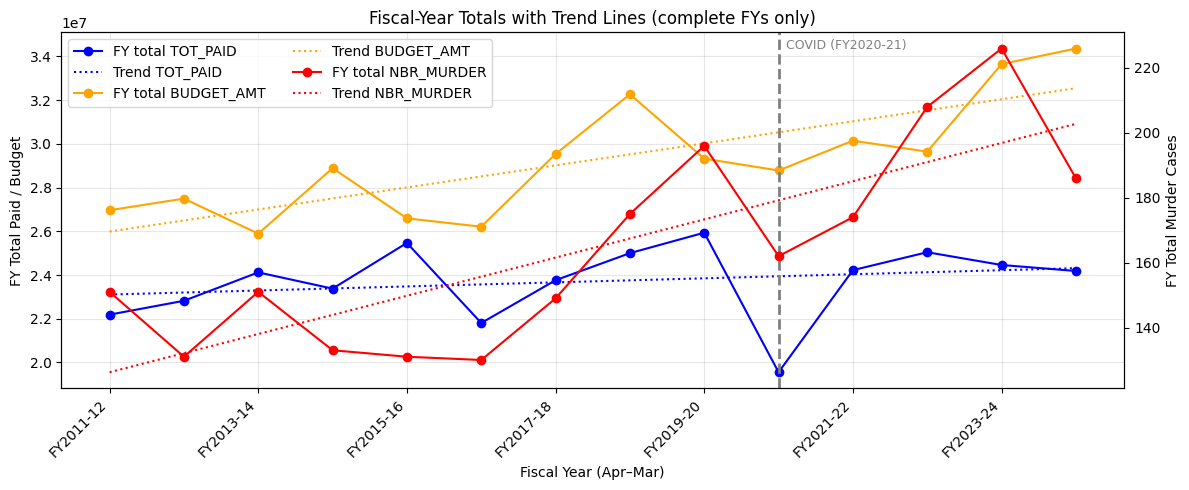

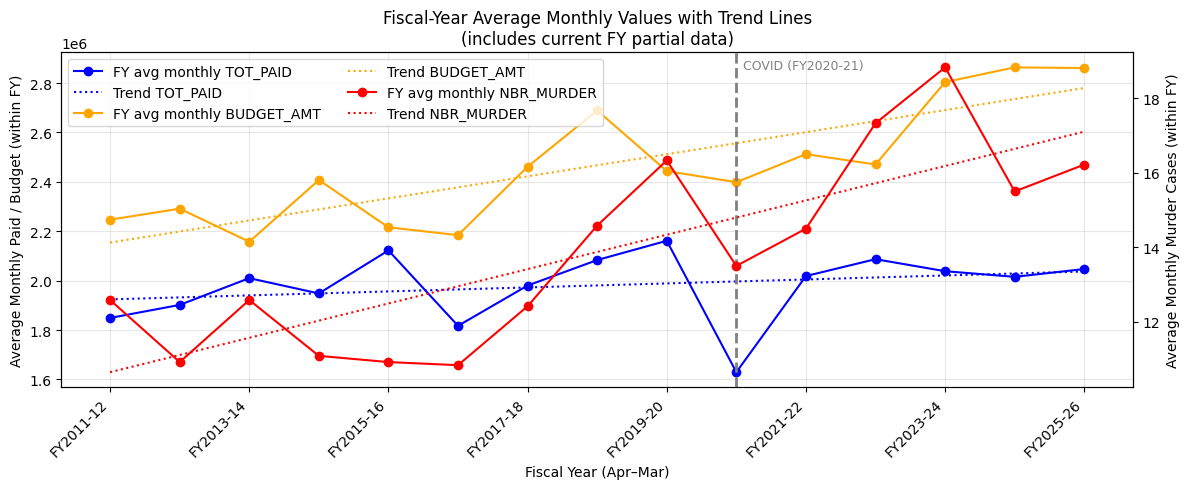

In [19]:
# Add a vertical separator line at FY2021-22 on BOTH plots
# (Totals plot excludes partial FY; Averages plot includes partial FY)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method - Prophet"
FILENAME = "data_input_monthly.csv"  # change if needed
PATH = os.path.join(BASE_DIR, FILENAME)

df = pd.read_csv(PATH)
df.columns = [c.strip() for c in df.columns]

DATE_COL = "ACC_MONTH"
REQ_COLS = ["TOT_PAID", "BUDGET_AMT", "NBR_MURDER"]
missing = [c for c in [DATE_COL] + REQ_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
for c in REQ_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

def fy_start_year(dt: pd.Timestamp) -> int:
    return dt.year if dt.month >= 4 else dt.year - 1

df["FY_START"] = df[DATE_COL].apply(fy_start_year)
df["FISCAL_YEAR"] = df["FY_START"].apply(lambda y: f"FY{y}-{str(y+1)[-2:]}")

# Complete vs partial FY (complete if 12 months of TOT_PAID)
fy_month_counts = df.groupby("FISCAL_YEAR")["TOT_PAID"].count()
complete_fys = fy_month_counts[fy_month_counts >= 12].index.tolist()

fy = (
    df.groupby("FISCAL_YEAR", as_index=False)
      .agg(
          n_months=("TOT_PAID", "count"),
          TOT_PAID_sum=("TOT_PAID", "sum"),
          BUDGET_AMT_sum=("BUDGET_AMT", "sum"),
          NBR_MURDER_sum=("NBR_MURDER", "sum"),
          TOT_PAID_mean=("TOT_PAID", "mean"),
          BUDGET_AMT_mean=("BUDGET_AMT", "mean"),
          NBR_MURDER_mean=("NBR_MURDER", "mean"),
      )
)

fy["FY_START"] = fy["FISCAL_YEAR"].str.extract(r"FY(\d{4})").astype(int)
fy = fy.sort_values("FY_START").reset_index(drop=True)

fy_complete = fy[fy["FISCAL_YEAR"].isin(complete_fys)].copy()
fy_all = fy.copy()

def simple_trend(y: np.ndarray) -> np.ndarray:
    x = np.arange(len(y))
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(y)
    if mask.sum() < 2:
        return np.full_like(y, np.nan)
    coeff = np.polyfit(x[mask], y[mask], 1)
    return np.polyval(coeff, x)

COLOR_BUDGET = "orange"
COLOR_MURDER = "red"
COLOR_PAID   = "blue"

# Helper: draw a vertical line at the FY2021-22 category position (if present)
# Helper: draw a vertical line at the FY2020-21 category position (if present)
def draw_fy_separator(ax, fy_labels, fy_break="FY2020-21", label = "COVID (FY2020-21)"):
    if fy_break in fy_labels:
        x_idx = fy_labels.index(fy_break)
        ax.axvline(x=x_idx, linestyle="--", linewidth=2, color="gray")
        ax.text(x_idx + 0.1, 0.98, label, transform=ax.get_xaxis_transform(),
                va="top", fontsize=9, color="gray")


# -----------------------------
# Plot 1: FY totals (complete FYs only) + separator
# -----------------------------
tot_paid_tr = simple_trend(fy_complete["TOT_PAID_sum"].values)
budget_tr   = simple_trend(fy_complete["BUDGET_AMT_sum"].values)
murder_tr   = simple_trend(fy_complete["NBR_MURDER_sum"].values)

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(fy_complete["FISCAL_YEAR"], fy_complete["TOT_PAID_sum"],
         linestyle="-", marker="o", color=COLOR_PAID, label="FY total TOT_PAID")
ax1.plot(fy_complete["FISCAL_YEAR"], tot_paid_tr,
         linestyle=":", color=COLOR_PAID, label="Trend TOT_PAID")

ax1.plot(fy_complete["FISCAL_YEAR"], fy_complete["BUDGET_AMT_sum"],
         linestyle="-", marker="o", color=COLOR_BUDGET, label="FY total BUDGET_AMT")
ax1.plot(fy_complete["FISCAL_YEAR"], budget_tr,
         linestyle=":", color=COLOR_BUDGET, label="Trend BUDGET_AMT")

ax1.set_xlabel("Fiscal Year (Apr–Mar)")
ax1.set_ylabel("FY Total Paid / Budget")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(fy_complete["FISCAL_YEAR"], fy_complete["NBR_MURDER_sum"],
         linestyle="-", marker="o", color=COLOR_MURDER, label="FY total NBR_MURDER")
ax2.plot(fy_complete["FISCAL_YEAR"], murder_tr,
         linestyle=":", color=COLOR_MURDER, label="Trend NBR_MURDER")
ax2.set_ylabel("FY Total Murder Cases")

ax1.set_title("Fiscal-Year Totals with Trend Lines (complete FYs only)")

# Vertical separator at FY2020-21 (use bottom axis)
fy_labels_tot = fy_complete["FISCAL_YEAR"].tolist()
draw_fy_separator(ax1, fy_labels_tot, "FY2020-21")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left", ncol=2)

step = 2
ax1.set_xticks(range(0, len(fy_labels_tot), step))
ax1.set_xticklabels([fy_labels_tot[i] for i in range(0, len(fy_labels_tot), step)],
                    rotation=45, ha="right")

plt.tight_layout()
plt.show()

# -----------------------------
# Plot 2: FY avg monthly values (includes partial current FY) + separator
# -----------------------------
tot_paid_tr2 = simple_trend(fy_all["TOT_PAID_mean"].values)
budget_tr2   = simple_trend(fy_all["BUDGET_AMT_mean"].values)
murder_tr2   = simple_trend(fy_all["NBR_MURDER_mean"].values)

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(fy_all["FISCAL_YEAR"], fy_all["TOT_PAID_mean"],
         linestyle="-", marker="o", color=COLOR_PAID, label="FY avg monthly TOT_PAID")
ax1.plot(fy_all["FISCAL_YEAR"], tot_paid_tr2,
         linestyle=":", color=COLOR_PAID, label="Trend TOT_PAID")

ax1.plot(fy_all["FISCAL_YEAR"], fy_all["BUDGET_AMT_mean"],
         linestyle="-", marker="o", color=COLOR_BUDGET, label="FY avg monthly BUDGET_AMT")
ax1.plot(fy_all["FISCAL_YEAR"], budget_tr2,
         linestyle=":", color=COLOR_BUDGET, label="Trend BUDGET_AMT")

ax1.set_xlabel("Fiscal Year (Apr–Mar)")
ax1.set_ylabel("Average Monthly Paid / Budget (within FY)")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(fy_all["FISCAL_YEAR"], fy_all["NBR_MURDER_mean"],
         linestyle="-", marker="o", color=COLOR_MURDER, label="FY avg monthly NBR_MURDER")
ax2.plot(fy_all["FISCAL_YEAR"], murder_tr2,
         linestyle=":", color=COLOR_MURDER, label="Trend NBR_MURDER")
ax2.set_ylabel("Average Monthly Murder Cases (within FY)")

ax1.set_title("Fiscal-Year Average Monthly Values with Trend Lines\n(includes current FY partial data)")

fy_labels_avg = fy_all["FISCAL_YEAR"].tolist()
draw_fy_separator(ax1, fy_labels_avg, "FY2020-21")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left", ncol=2)

ax1.set_xticks(range(0, len(fy_labels_avg), step))
ax1.set_xticklabels([fy_labels_avg[i] for i in range(0, len(fy_labels_avg), step)],
                    rotation=45, ha="right")

plt.tight_layout()
plt.show()


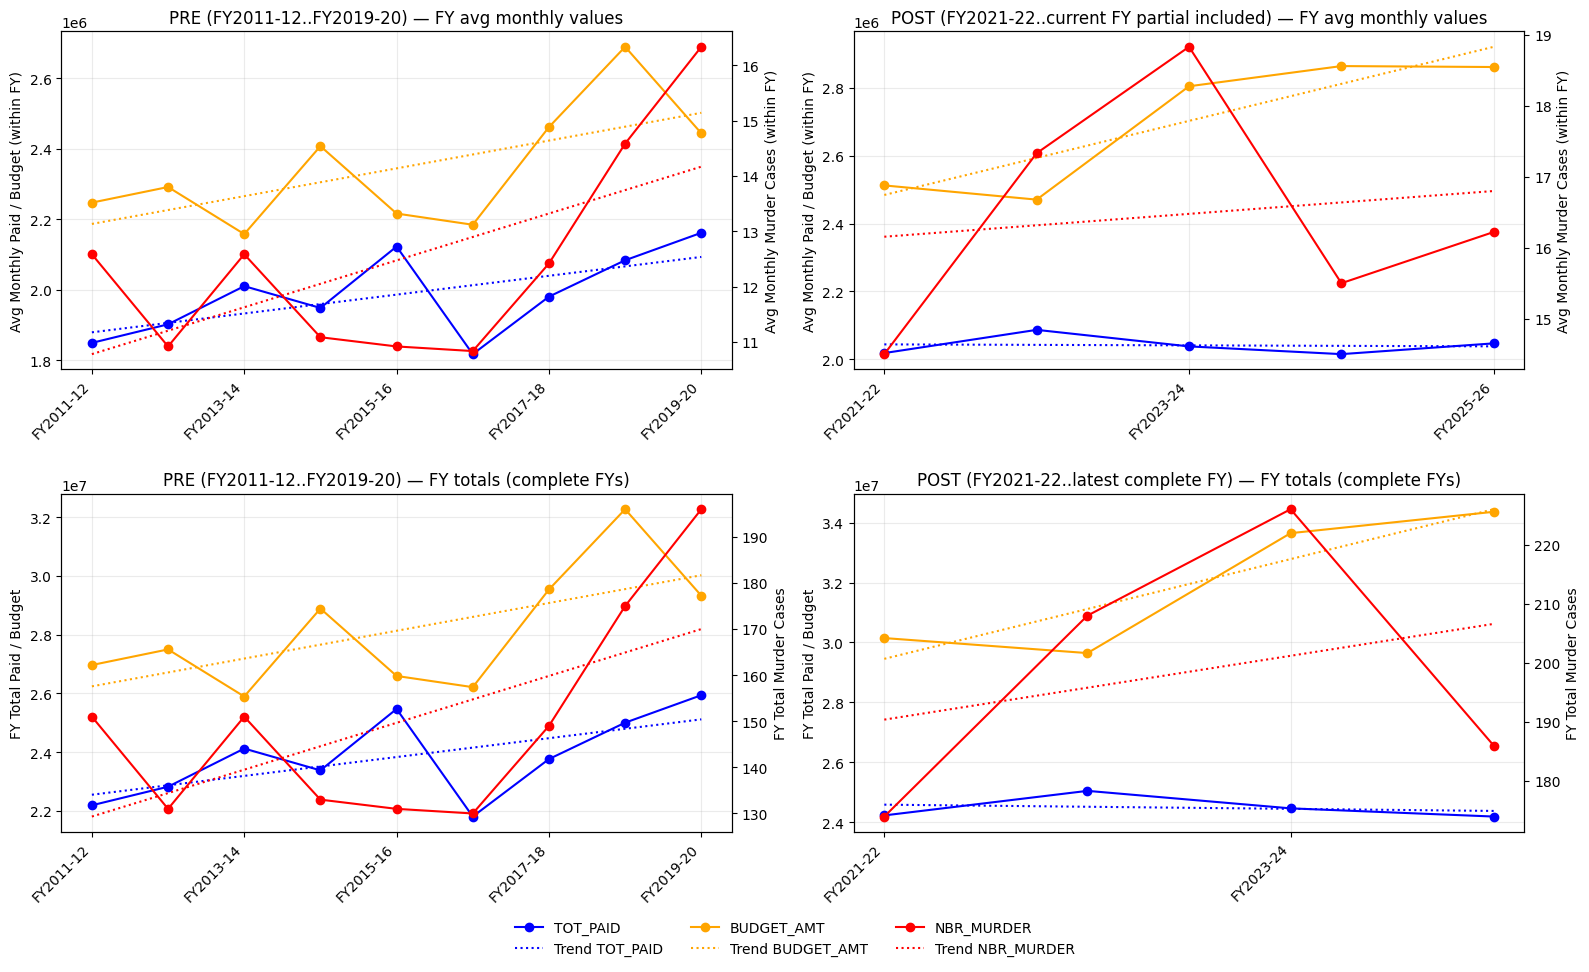

In [14]:
# 2x2 matrix (UPDATED windows):
#   Row 1: FY avg monthly values  (PRE | POST)
#   Row 2: FY totals              (PRE | POST)
#   Legend: bottom (shared)
#
# Windows:
#   PRE  = FY2011-12 .. FY2019-20
#   POST = FY2021-22 .. latest available
# Excludes only: FY2020-21

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method - Prophet"
FILENAME = "data_input_monthly.csv"  # change if needed
PATH = os.path.join(BASE_DIR, FILENAME)

df = pd.read_csv(PATH)
df.columns = [c.strip() for c in df.columns]

DATE_COL = "ACC_MONTH"
REQ_COLS = ["TOT_PAID", "BUDGET_AMT", "NBR_MURDER"]
missing = [c for c in [DATE_COL] + REQ_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
for c in REQ_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

def fy_start_year(dt: pd.Timestamp) -> int:
    return dt.year if dt.month >= 4 else dt.year - 1

df["FY_START"] = df[DATE_COL].apply(fy_start_year)
df["FISCAL_YEAR"] = df["FY_START"].apply(lambda y: f"FY{y}-{str(y+1)[-2:]}")

# complete FY = 12 months of TOT_PAID
fy_month_counts = df.groupby("FISCAL_YEAR")["TOT_PAID"].count()
complete_fys = set(fy_month_counts[fy_month_counts >= 12].index)

fy = (
    df.groupby("FISCAL_YEAR", as_index=False)
      .agg(
          n_months=("TOT_PAID", "count"),
          TOT_PAID_sum=("TOT_PAID", "sum"),
          BUDGET_AMT_sum=("BUDGET_AMT", "sum"),
          NBR_MURDER_sum=("NBR_MURDER", "sum"),
          TOT_PAID_mean=("TOT_PAID", "mean"),
          BUDGET_AMT_mean=("BUDGET_AMT", "mean"),
          NBR_MURDER_mean=("NBR_MURDER", "mean"),
      )
)

fy["FY_START"] = fy["FISCAL_YEAR"].str.extract(r"FY(\d{4})").astype(int)
fy = fy.sort_values("FY_START").reset_index(drop=True)

# ----- Windows (exclude only FY2020-21) -----
EXCLUDED_FYS = {"FY2020-21"}

PRE_FYS  = {f"FY{y}-{str(y+1)[-2:]}" for y in range(2011, 2020)}   # FY2011-12..FY2019-20
POST_FYS = {f"FY{y}-{str(y+1)[-2:]}" for y in range(2021, 2100)}   # FY2021-22..latest

fy = fy[~fy["FISCAL_YEAR"].isin(EXCLUDED_FYS)].copy()
fy_pre  = fy[fy["FISCAL_YEAR"].isin(PRE_FYS)].copy()
fy_post = fy[fy["FISCAL_YEAR"].isin(POST_FYS)].copy()

# Totals: complete FYs only (so current partial FY will NOT show in totals)
fy_pre_tot  = fy_pre[fy_pre["FISCAL_YEAR"].isin(complete_fys)].copy()
fy_post_tot = fy_post[fy_post["FISCAL_YEAR"].isin(complete_fys)].copy()

# Averages: include partial FY for post
fy_pre_avg  = fy_pre.copy()
fy_post_avg = fy_post.copy()

def simple_trend(y: np.ndarray) -> np.ndarray:
    x = np.arange(len(y))
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(y)
    if mask.sum() < 2:
        return np.full_like(y, np.nan)
    coeff = np.polyfit(x[mask], y[mask], 1)
    return np.polyval(coeff, x)

# Colors requested
COLOR_BUDGET = "orange"
COLOR_MURDER = "red"
COLOR_PAID   = "blue"

def plot_panel(ax, axr, fy_panel, y_paid, y_budget, y_murder, title, ylabel_left, ylabel_right):
    """Plot one panel on ax (left) + axr (right) with dotted trends."""
    if fy_panel.empty:
        ax.set_title(title + "\n[No data]")
        ax.axis("off")
        return

    paid = fy_panel[y_paid].values
    bud  = fy_panel[y_budget].values
    mur  = fy_panel[y_murder].values

    paid_tr = simple_trend(paid)
    bud_tr  = simple_trend(bud)
    mur_tr  = simple_trend(mur)

    x = np.arange(len(fy_panel))
    labels = fy_panel["FISCAL_YEAR"].tolist()

    ax.plot(x, paid, color=COLOR_PAID, marker="o", linestyle="-", label="TOT_PAID")
    ax.plot(x, paid_tr, color=COLOR_PAID, linestyle=":", label="Trend TOT_PAID")

    ax.plot(x, bud, color=COLOR_BUDGET, marker="o", linestyle="-", label="BUDGET_AMT")
    ax.plot(x, bud_tr, color=COLOR_BUDGET, linestyle=":", label="Trend BUDGET_AMT")

    ax.set_title(title)
    ax.set_ylabel(ylabel_left)
    ax.grid(True, alpha=0.25)

    axr.plot(x, mur, color=COLOR_MURDER, marker="o", linestyle="-", label="NBR_MURDER")
    axr.plot(x, mur_tr, color=COLOR_MURDER, linestyle=":", label="Trend NBR_MURDER")
    axr.set_ylabel(ylabel_right)

    step = 2
    ax.set_xticks(x[::step])
    ax.set_xticklabels([labels[i] for i in range(0, len(labels), step)], rotation=45, ha="right")

# -----------------------------
# Build 2x2 figure (Row 1 = averages; Row 2 = totals)
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Row 1: averages
ax00, ax01 = axes[0, 0], axes[0, 1]
ax00r, ax01r = ax00.twinx(), ax01.twinx()

plot_panel(
    ax00, ax00r, fy_pre_avg,
    y_paid="TOT_PAID_mean", y_budget="BUDGET_AMT_mean", y_murder="NBR_MURDER_mean",
    title="PRE (FY2011-12..FY2019-20) — FY avg monthly values",
    ylabel_left="Avg Monthly Paid / Budget (within FY)",
    ylabel_right="Avg Monthly Murder Cases (within FY)",
)
plot_panel(
    ax01, ax01r, fy_post_avg,
    y_paid="TOT_PAID_mean", y_budget="BUDGET_AMT_mean", y_murder="NBR_MURDER_mean",
    title="POST (FY2021-22..current FY partial included) — FY avg monthly values",
    ylabel_left="Avg Monthly Paid / Budget (within FY)",
    ylabel_right="Avg Monthly Murder Cases (within FY)",
)

# Row 2: totals (complete FYs only)
ax10, ax11 = axes[1, 0], axes[1, 1]
ax10r, ax11r = ax10.twinx(), ax11.twinx()

plot_panel(
    ax10, ax10r, fy_pre_tot,
    y_paid="TOT_PAID_sum", y_budget="BUDGET_AMT_sum", y_murder="NBR_MURDER_sum",
    title="PRE (FY2011-12..FY2019-20) — FY totals (complete FYs)",
    ylabel_left="FY Total Paid / Budget",
    ylabel_right="FY Total Murder Cases",
)
plot_panel(
    ax11, ax11r, fy_post_tot,
    y_paid="TOT_PAID_sum", y_budget="BUDGET_AMT_sum", y_murder="NBR_MURDER_sum",
    title="POST (FY2021-22..latest complete FY) — FY totals (complete FYs)",
    ylabel_left="FY Total Paid / Budget",
    ylabel_right="FY Total Murder Cases",
)

# -----------------------------
# Shared legend at the bottom
# -----------------------------
hL, lL = ax00.get_legend_handles_labels()
hR, lR = ax00r.get_legend_handles_labels()

fig.legend(
    hL + hR, lL + lR,
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.01)
)

plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()
